# Radial Velocity Analysis
- Code reconstructed from the [Planet Hunter Epsode 38](https://www.youtube.com/watch?v=yjliMlCkzv0&list=PLpTcgCRPTgRk3uXOM6Ee5A1Y1F61zOXBz&index=39) by Nora Eisner
- Data Prep
    - Go to [ESO](https://archive.eso.org/scienceportal/home)
    - Enter `TIC 266980320`
    - Click `Download Data` from the upper right of the page.
    - In the download page, select `Science.Spectrum` and `ANCILIARY.HARPSTAR`, then `Download ZIP File`
    - After download, unzip the file, where the directory contains `*.fits` files and `*.tar` files.
    - The first half of the notebook uses the fits files to show the wavelength vs intensity diagram.
    - Then unpack all the tar files using `find . -name "*.tar" -exec tar -xvf {} \;`
    - Extract `HIERARCH ESO DRS BJD` and `HIERARCH ESO DRS CCF RVC` fields from the header of the unpacked files, which can be used for radial velocity analysis.

In [76]:
import radvel
import lightkurve as lk
import matplotlib.pyplot as plt
from glob import glob
import astropy.io.fits as pf
import numpy as np

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

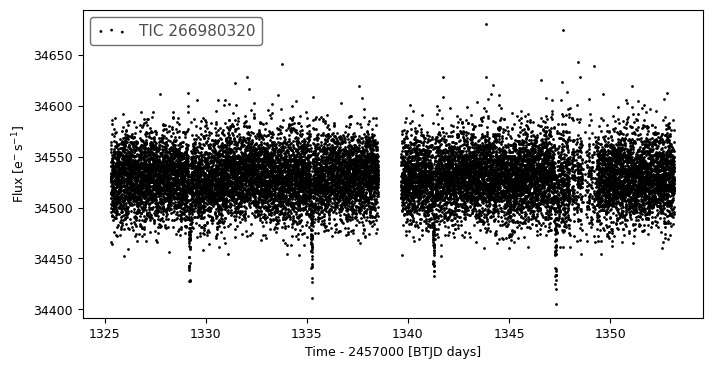

In [3]:
TIC = "TIC 266980320"

sector_data = lk.search_lightcurve(TIC, author='SPOC', exptime=120)
lc = sector_data[0].download()
fig, ax = plt.subplots(figsize=(8, 4))
lc.scatter(ax=ax, c='k')


In [157]:
files = glob("/Users/sophia268238/GitHub/astronomy_ml/data/TIC_266980320/archive/*.fits")

Text(0.5, 0, 'Wave Length($\\mathrm{\\AA})$')

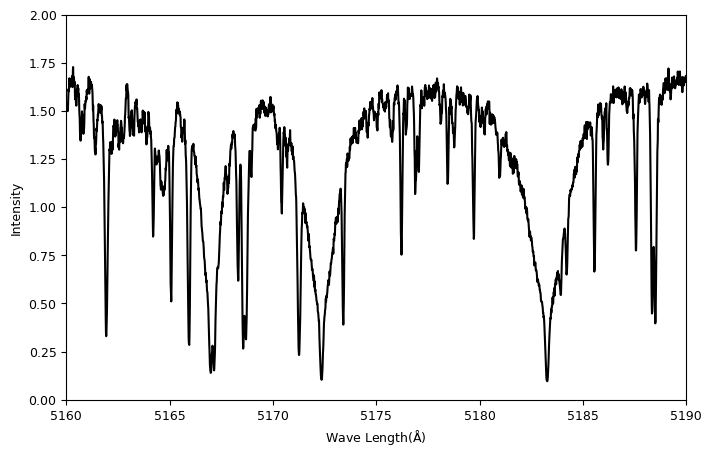

In [161]:
data = pf.open(files[0])
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(data[1].data["WAVE"][0], data[1].data["FLUX"][0]/4000, c='k')
ax.set_xlim(5160, 5190)
ax.set_ylim(0, 2)
ax.set_ylabel("Intensity")
ax.set_xlabel("Wave Length($\mathrm{\AA})$")

In [68]:
files = glob("/Users/sophia268238/GitHub/astronomy_ml/data/TIC_266980320/archive/data/*/*/*ccf_G2_A.fits")
data = pf.open(files[1])
header = data[0].header

In [69]:
time = header['HIERARCH ESO DRS BJD']
rv = header['HIERARCH ESO DRS CCF RVC']

In [70]:
time, rv

(2458396.75606486, -20.1028751862429)

In [109]:
time_list, rv_raw_list = zip(*[[data.header['HIERARCH ESO DRS BJD'], data.header['HIERARCH ESO DRS CCF RVC'] * 1000] for f in files for data in pf.open(f)])

Text(0.5, 0, 'Time(BJD)')

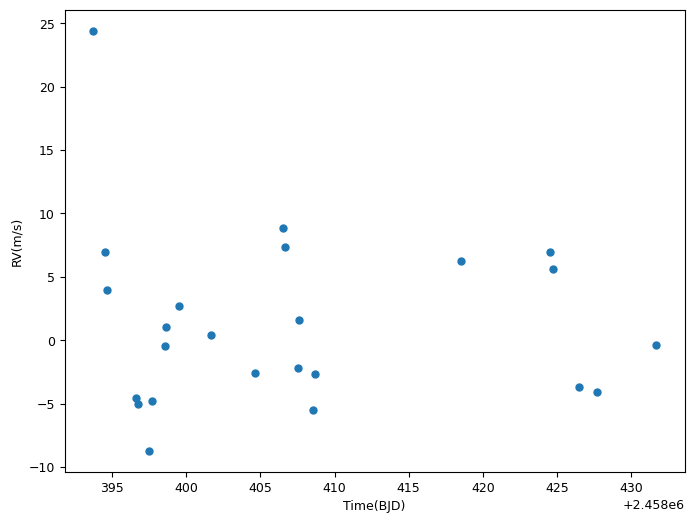

In [110]:
rv_list = rv_raw_list - np.median(rv_raw_list)
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(x=time_list, y=rv_list)
ax.set_ylabel('RV(m/s)')
ax.set_xlabel('Time(BJD)')

Text(0.5, 0, 'Time(BJD)')

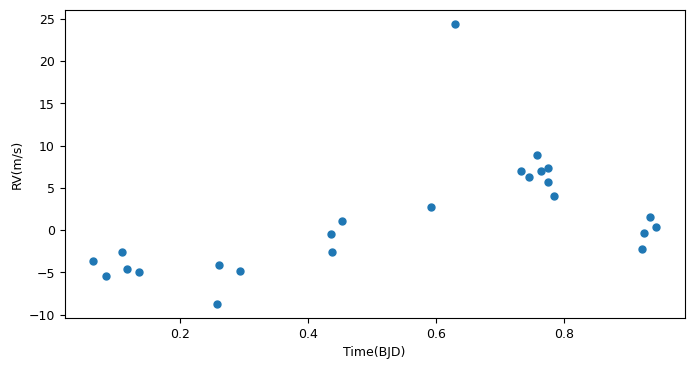

In [122]:
period = 6.03607
T0 = 8329.1996 + 2457000
phased_time = np.array([(t - T0 * period) % period / period for t in time_list])

fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(x=phased_time, y=rv_list)
ax.set_ylabel('RV(m/s)')
ax.set_xlabel('Time(BJD)')

In [112]:
def get_rv_curve_single(time_arry, t0, P, ecc, omega, i, gamma, k):
    true_anom = radvel.orbit.true_anomaly(time_arry, t0, P, ecc)
    rv = gamma + k * (ecc * np.cos(omega) + np.cos(true_anom + omega))
    return rv

In [147]:
ecc = 0 # eccentricity
omega = 0 # in radians
i = 86.38 # inclination of the orbit
gamma = 0 # offset
k = 6.1 # the amplitude of the RV signal (how much wobble)

In [107]:
time_array = np.linspace(np.nanmin(time_list), np.nanmax(time_list), 1000)
rv_curve = get_rv_curve_single(time_array, T0, period, ecc, omega, i, gamma, k)

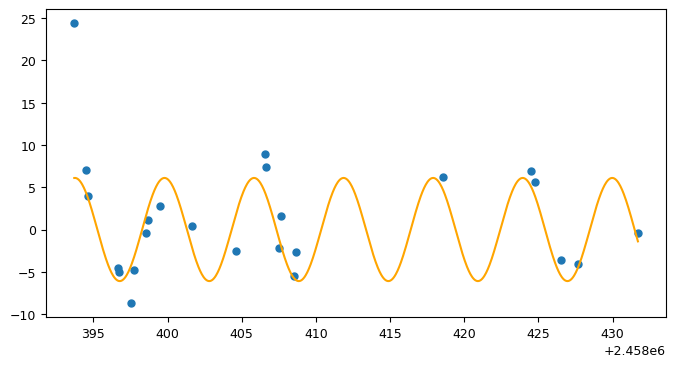

In [121]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(x=time_list, y = rv_list)
ax.plot(time_array, rv_curve, color='orange')

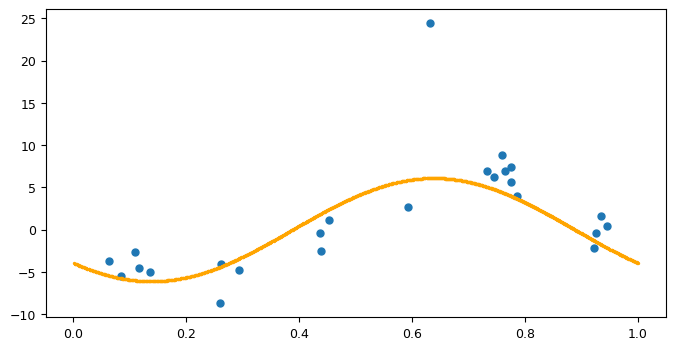

In [141]:
phased_model = np.array([(t - T0 * period) % period / period for t in time_array])

fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(x=phased_time, y = rv_list)
ax.scatter(phased_model, rv_curve, color='orange', s=2)

In [152]:
import astropy.units as u
import astropy.constants as c
mass_star = 0.92 * u.Msun
def det_mass(mass_star, k, period):
    period = period * u.day
    k = k * u.m / u.s
    return (((mass_star ** 2) * period) / (2 * np.pi * c.G)) ** (1. / 3.) * k

In [153]:
planet_mass = det_mass(mass_star, k, period).to("Mearth")
print(planet_mass)

16.429378171400185 earthMass
